In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("SeoulBikeData.csv", encoding="unicode_escape")


print(df.head())
print(df.info())
print(df.describe())


         Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0  01/12/2017                254     0             -5.2           37   
1  01/12/2017                204     1             -5.5           38   
2  01/12/2017                173     2             -6.0           39   
3  01/12/2017                107     3             -6.2           40   
4  01/12/2017                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   


In [2]:
# Clean column names
df.columns = [
    col.strip().lower()
       .replace(' ', '_')
       .replace('(', '')
       .replace(')', '')
       .replace('°c', 'c')
       .replace('%', 'pct')
       .replace('/', '_')
       .replace('.', '')
       for col in df.columns
]

# Convert to category
categorical_cols = ['seasons', 'holiday', 'functioning_day', 'hour']
for col in categorical_cols:
    df[col] = df[col].astype('category')

print(df[categorical_cols].dtypes)


seasons            category
holiday            category
functioning_day    category
hour               category
dtype: object


In [3]:
df = df[df['functioning_day'] == 'Yes'].copy()
df['datetime'] = pd.to_datetime(df['date'], format="%d/%m/%Y") + pd.to_timedelta(df['hour'].astype(int), unit='h')

df = df.sort_values('datetime')

# Create weekday and month
df['weekday'] = df['datetime'].dt.dayofweek  # Monday=0, Sunday=6
df['month'] = df['datetime'].dt.month

# convert to category
df['weekday'] = df['weekday'].astype('category')
df['month'] = df['month'].astype('category')

print(df[['datetime', 'hour', 'weekday', 'month']].head())


             datetime hour weekday month
0 2017-12-01 00:00:00    0       4    12
1 2017-12-01 01:00:00    1       4    12
2 2017-12-01 02:00:00    2       4    12
3 2017-12-01 03:00:00    3       4    12
4 2017-12-01 04:00:00    4       4    12


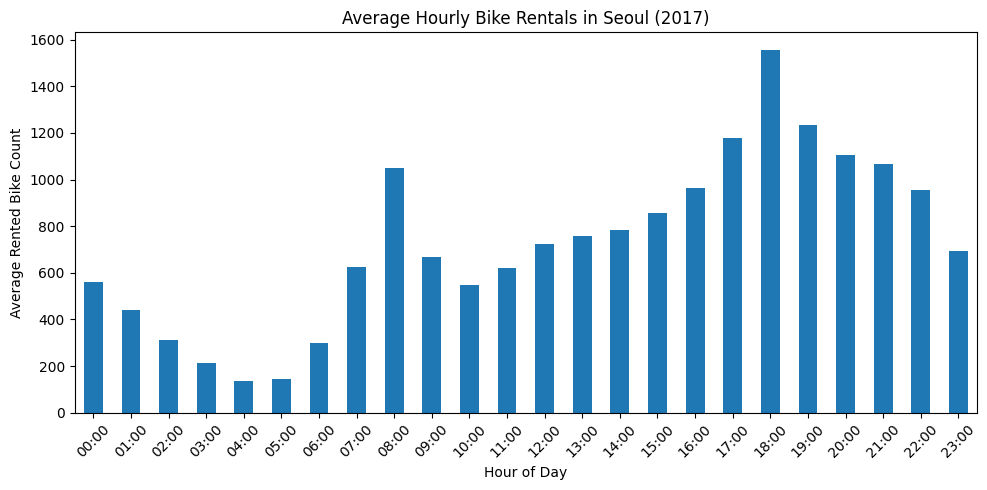

In [4]:
import matplotlib.pyplot as plt

hourly_avg = df.groupby('hour')['rented_bike_count'].mean()

plt.figure(figsize=(10, 5))
hourly_avg.plot(kind='bar')

plt.xticks(ticks=range(24), labels=[f"{h:02d}:00" for h in range(24)], rotation=45)

plt.xlabel("Hour of Day")
plt.ylabel("Average Rented Bike Count")
plt.title("Average Hourly Bike Rentals in Seoul (2017)")

plt.tight_layout()
plt.show()


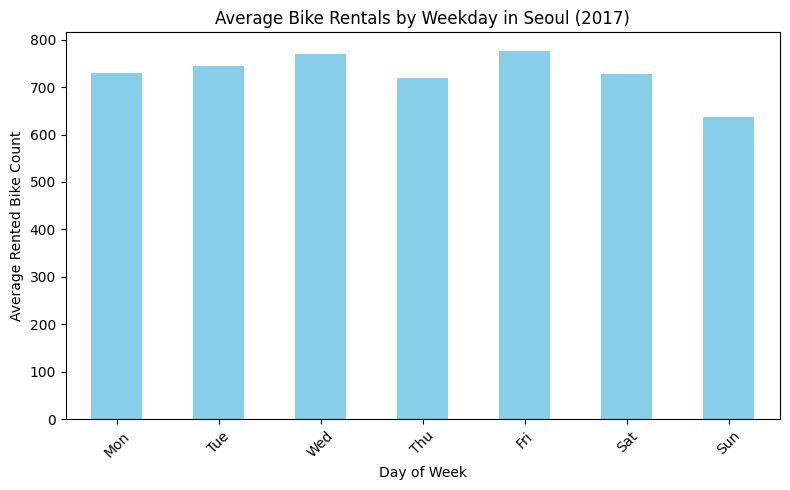

In [5]:
import matplotlib.pyplot as plt

weekday_avg = df.groupby('weekday')['rented_bike_count'].mean()

weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekday_avg.index = [weekday_names[int(i)] for i in weekday_avg.index]

plt.figure(figsize=(8, 5))
weekday_avg.plot(kind='bar', color='skyblue')

plt.xlabel("Day of Week")
plt.ylabel("Average Rented Bike Count")
plt.title("Average Bike Rentals by Weekday in Seoul (2017)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


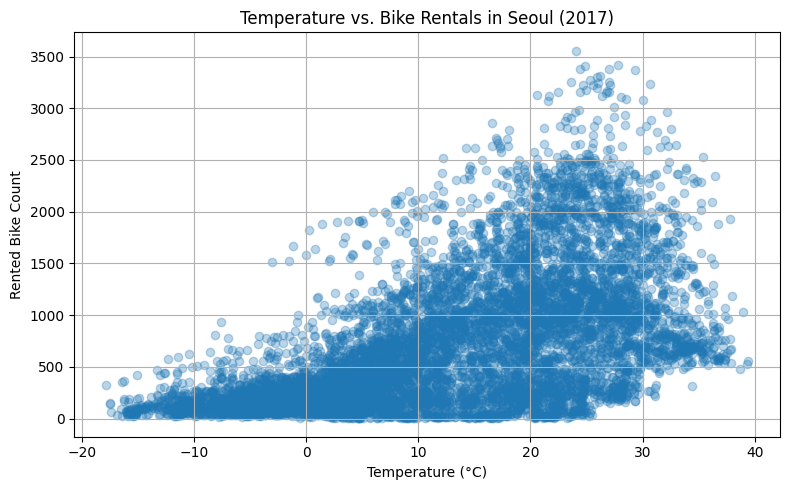

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(df['temperaturec'], df['rented_bike_count'], alpha=0.3)

plt.xlabel("Temperature (°C)")
plt.ylabel("Rented Bike Count")
plt.title("Temperature vs. Bike Rentals in Seoul (2017)")

plt.grid(True)
plt.tight_layout()
plt.show()


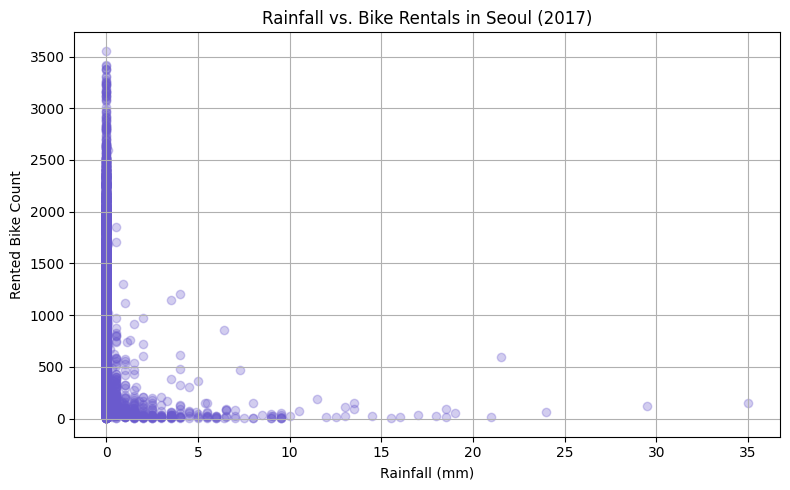

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(df['rainfallmm'], df['rented_bike_count'], alpha=0.3, color='slateblue')

plt.xlabel("Rainfall (mm)")
plt.ylabel("Rented Bike Count")
plt.title("Rainfall vs. Bike Rentals in Seoul (2017)")

plt.grid(True)
plt.tight_layout()
plt.show()


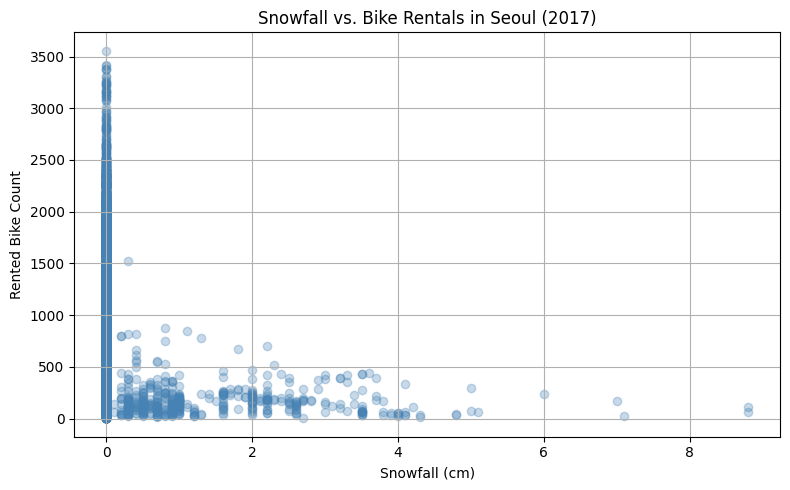

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(df['snowfall_cm'], df['rented_bike_count'], alpha=0.3, color='steelblue')

plt.xlabel("Snowfall (cm)")
plt.ylabel("Rented Bike Count")
plt.title("Snowfall vs. Bike Rentals in Seoul (2017)")
plt.grid(True)
plt.tight_layout()
plt.show()


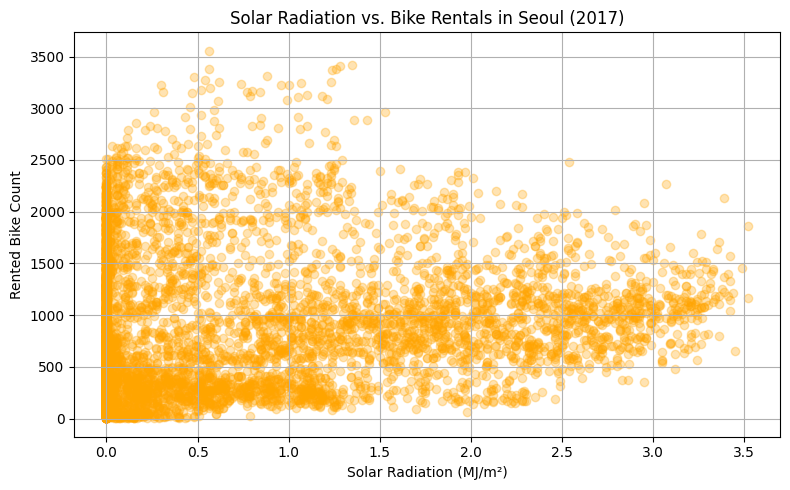

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(df['solar_radiation_mj_m2'], df['rented_bike_count'], alpha=0.3, color='orange')

plt.xlabel("Solar Radiation (MJ/m²)")
plt.ylabel("Rented Bike Count")
plt.title("Solar Radiation vs. Bike Rentals in Seoul (2017)")

plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
import numpy as np

# One-hot encoding for seasons
df_onehot = 1. * pd.get_dummies(df['seasons'])
df = pd.concat([df, df_onehot], axis=1)


# define hour bins
bins = [-1, 6, 9, 17, 19, 24]
labels = ['phase0to6', 'phase7to9', 'phase10to17', 'phase18to19', 'phase20to24']

# Create binned categorical feature
df['time_bin'] = pd.cut(
    df['hour'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)
df_hour_onehot = 1. * pd.get_dummies(df['time_bin'])
df = pd.concat([df, df_hour_onehot], axis=1)

# Binary indicator for rainfall (1 if rainfall > 0 mm)
df['is_raining'] = (df['rainfallmm'] > 0).astype(int)

# Binary indicator for snowfall (1 if snowfall > 0 cm)
df['is_snowing'] = (df['snowfall_cm'] > 0).astype(int)

# Squared term for temperature to capture nonlinear effects
df['temperaturec_squared'] = df['temperaturec'] ** 2

# Binary indicator for weekend (Saturday=5 or Sunday=6)
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

# Binary indicator for holiday
df['is_holiday'] = (df['holiday'] != 'No Holiday').astype(int)

# Binary indicator for working day (weekday and functioning)
df['is_working_day'] = ((df['functioning_day'] == 'Yes') & (df['weekday'].isin([0,1,2,3,4]))).astype(int)

df['temp_rain'] = df['temperaturec'] * df['is_raining']
df['temp_snow'] = df['temperaturec'] * df['is_snowing']
df['humid_rain'] = df['humiditypct'] * df['is_raining']

# Add lag and rolling features
df['lag_1'] = df['rented_bike_count'].shift(1)
df['lag_24'] = df['rented_bike_count'].shift(24)
df['rolling_24_mean'] = df['rented_bike_count'].shift(1).rolling(24).mean()
df['rolling_168_mean'] = df['rented_bike_count'].shift(1).rolling(168).mean()


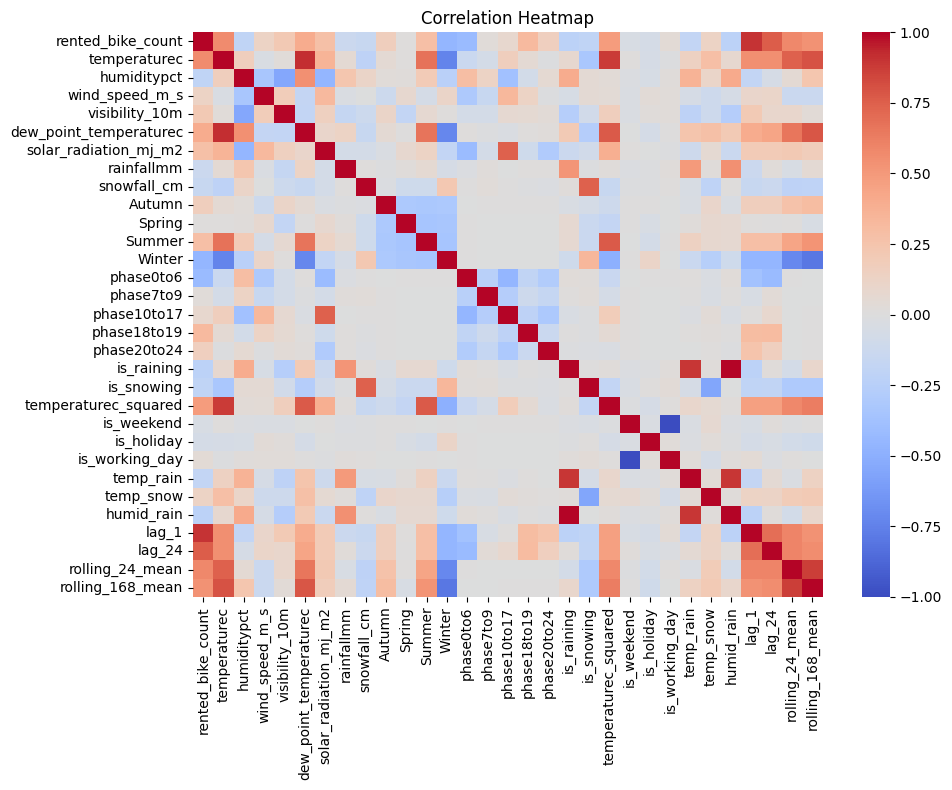

In [11]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


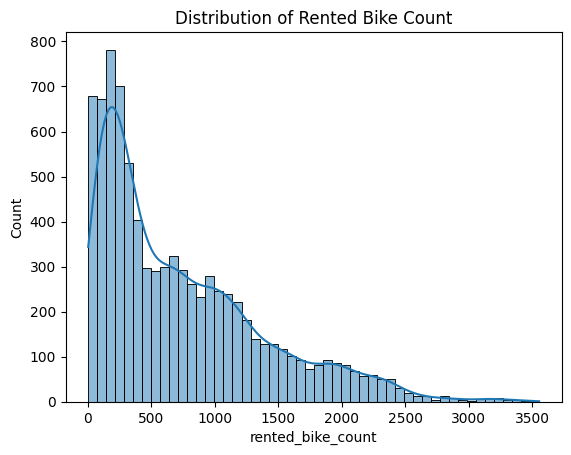

In [12]:
import seaborn as sns
sns.histplot(df['rented_bike_count'], bins=50, kde=True)
plt.title("Distribution of Rented Bike Count")
plt.show()


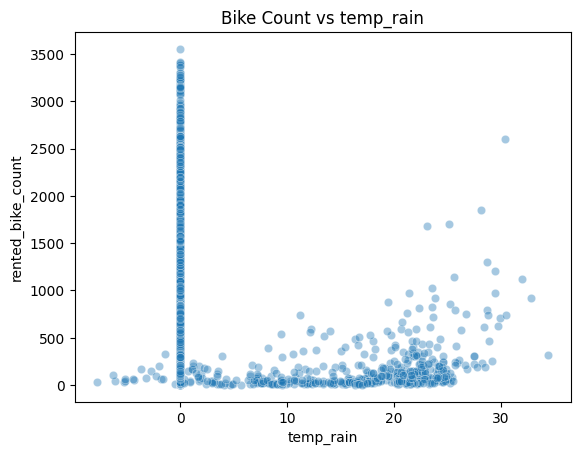

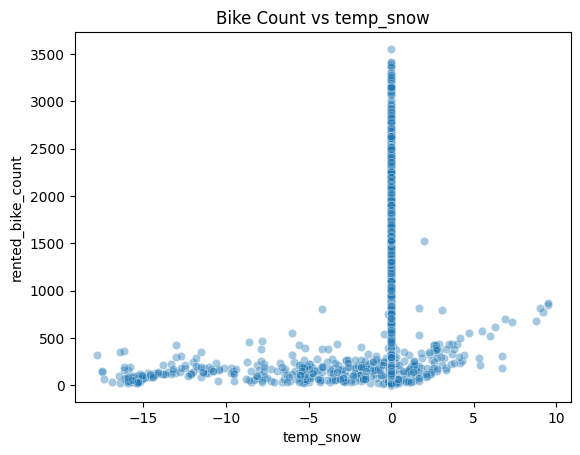

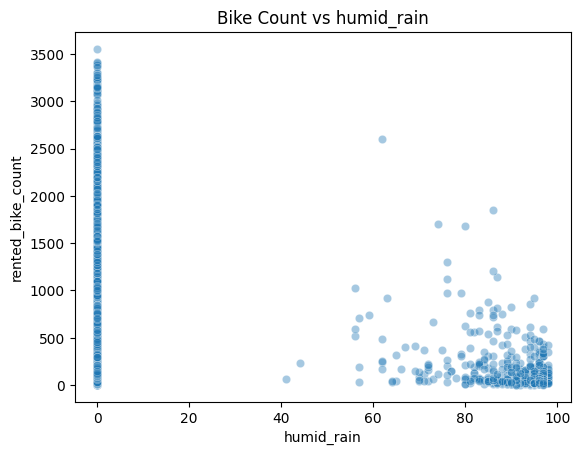

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x='temp_rain', y='rented_bike_count', alpha=0.4)
plt.title("Bike Count vs temp_rain")
plt.show()

sns.scatterplot(data=df, x='temp_snow', y='rented_bike_count', alpha=0.4)
plt.title("Bike Count vs temp_snow")
plt.show()

sns.scatterplot(data=df, x='humid_rain', y='rented_bike_count', alpha=0.4)
plt.title("Bike Count vs humid_rain")
plt.show()



In [14]:
df.dropna().to_csv("SeoulBikeDataClean.csv", index=False)